# First order methods on regression models

    Lab 2 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 18th of February at 23:55**  to **gowerrobert@gmail.com**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [92]:
# Change here using YOUR first and last names
fn1 = "Henriette Flore"
ln1 = "KENNE"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_kenne_henriette flore.ipynb


In [93]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

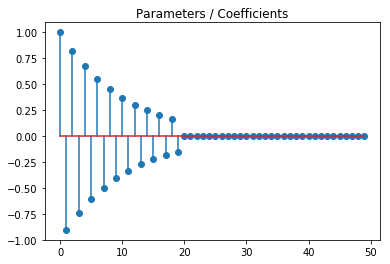

In [95]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [96]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [97]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x""" 
    n = len(x)
    z = np.ones(n)
    for i in range (len(x)):
        if s<x[i]:
            z[i]= x[i]-s
        elif x[i]<-s:
            z[i]= x[i]+ s
        else:
            z[i] = 0
    return z # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x,ord=1) # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x""" 
    z = x/(s+1)
    return z # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s/2)*(norm(x))**2 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

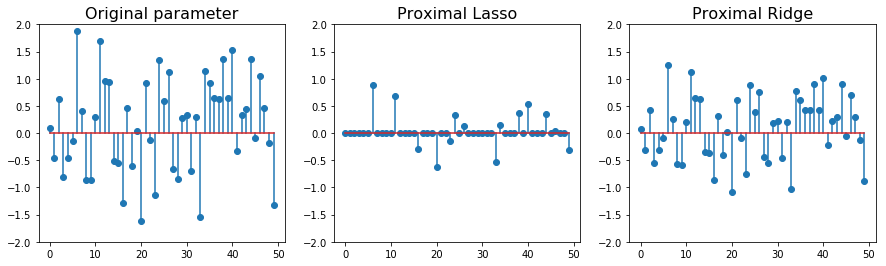

In [98]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## We observe that Proximal do the feature selection compare to Proximal Ridge

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [99]:
def loss_linreg(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_linreg(x):
    """Leas-squares gradient"""
    return -(A.T @ (b - A.dot(x)))/n_samples # TODO


def loss_logreg(x):
    u = b * A.dot(x)
    return np.sum(np.log(1 + np.exp(-u))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    
    S = np.zeros(len(x)) 
    for i in range(n_samples):
        u = -b[i] * A[i]
        S += u /(1 + np.exp(-u.dot(x)))
    return S/n_samples# TODO

# TO BE COMPLETED

In [100]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
from scipy.optimize import check_grad
lossgrad = check_grad(loss_linreg,grad_linreg,x)
#check_grad(loss_linreg, grad_linreg,x)
lossgrad

3.4147450926507146e-06

In [101]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
from scipy.optimize import check_grad
losgrad = check_grad(loss_logreg,grad_logreg,x)
#check_grad(loss_linreg, grad_linreg,x)
losgrad

1.56166178466536e-07

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

In [102]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    return np.trace(A.T @ A)/n_samples# TODO
    
        
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return np.trace(A.T @ A)/(4*n_samples)# TODO
    
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy() 
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x - step*grad_f(x), step*s) #### TODO ####
        x = x_new

        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [103]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(z- step*grad_f(z), step*s)
        t_new = (1+np.sqrt(1 + 4*(t)**2))/2
        z = x_new + ((t-1)*(x_new - x))/t_new
        t = t_new
        x = x_new
        
        #### TODO ####

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [104]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

##  PLot Error and Objectives for ISAT and FISTA

In [105]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)

In [106]:
x_ista, objectives_ista, errors_ista = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, \
                                            1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)

x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                                1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)

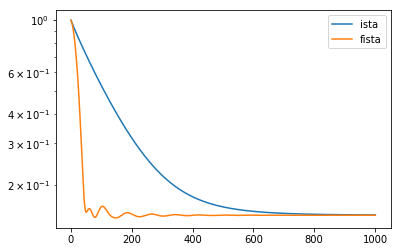

In [107]:
plt.semilogy(errors_ista)
plt.semilogy(errors_fista)
plt.legend(['ista','fista'])

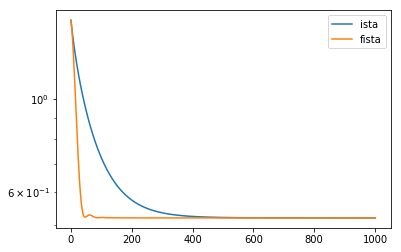

In [108]:
plt.semilogy(objectives_ista)
plt.semilogy(objectives_fista)
plt.legend(['ista','fista'])

In [109]:
#norm(x_fista - x_ista)

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

##  Compute a prcise minimum and minimizer dro linear regression with rigde penalization

In [110]:
x_star, objectives, errors = ista(x0, loss_linreg, grad_linreg, \
                                  ridge, prox_ridge, 1/lip_linreg(A), s=s,\
                                  n_iter=10000, x_true=coefs, verbose=False)

In [111]:
x_fistopt, objectives_fista, errors_fistopt = fista(x0, loss_linreg, grad_linreg, \
                                                    ridge, prox_ridge, 1/lip_linreg(A), s=s,\
                                                    n_iter=1000, x_true=x_star, verbose=False)

In [112]:
x_istopt, objectives_ista, errors_istopt = ista(x0, loss_linreg, grad_linreg, ridge, \
                                                 prox_ridge, 1/lip_linreg(A), s=s, n_iter=1000,\
                                                 
                                                 x_true=x_star, verbose=False)

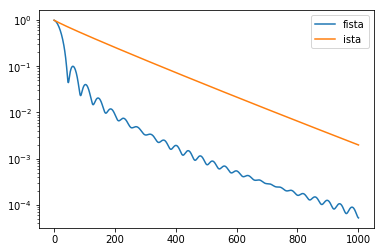

In [113]:
plt.semilogy(errors_fistopt)
plt.semilogy(errors_istopt)
plt.legend(['fista','ista'])

##  Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer

In [114]:
x_ista, objectives_ista, errors = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                  1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)

x_fista, objectives_fista, errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                    1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)

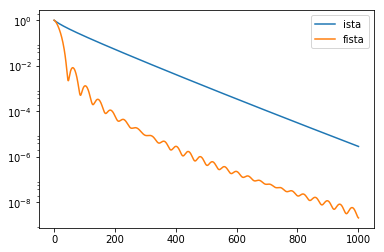

In [115]:
min_objective = min(objectives)

n=len(objectives_ista)
minobji=np.zeros(n)
minobjf=np.zeros(n)

for i in range(n):
    minobji[i]= objectives_ista[i]-min_objective
    minobjf[i]= objectives_fista[i]-min_objective
    
plt.semilogy(minobji,label='ista')
plt.semilogy(minobjf,label='fista')  
plt.legend()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

## Compare the solution you obtain with ista and fista with the true parameter coefs of the model. Plot plt.stem .

(-2, 2)

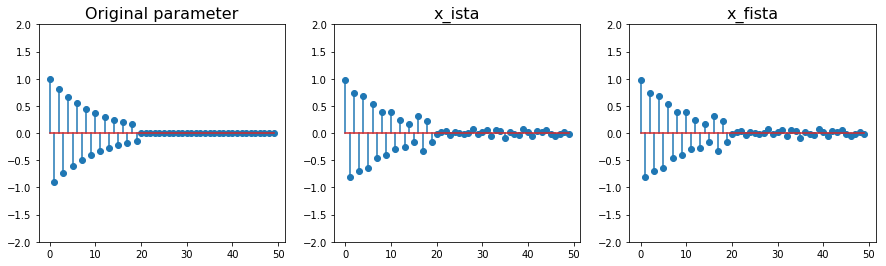

In [116]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(x_ista)
plt.title("x_ista", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(x_fista)
plt.title("x_fista", fontsize=16)
plt.ylim([-2, 2])

## In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.

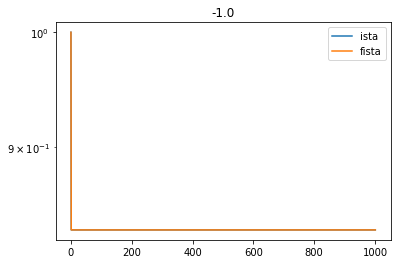

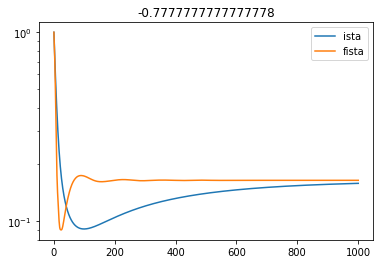

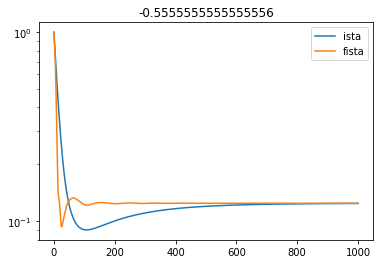

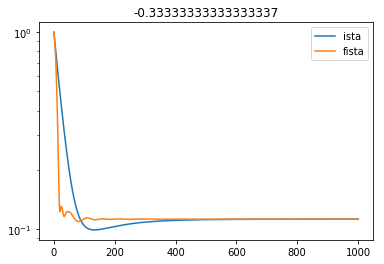

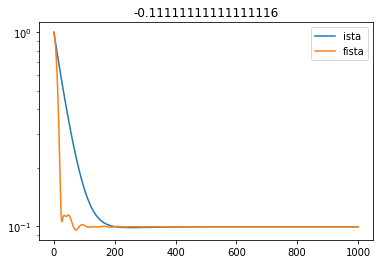

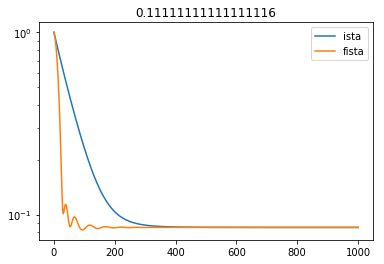

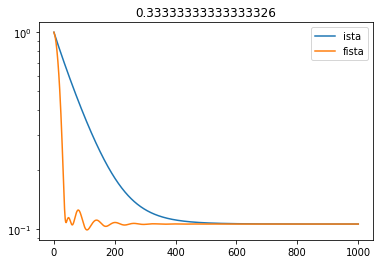

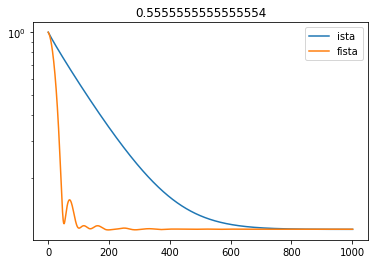

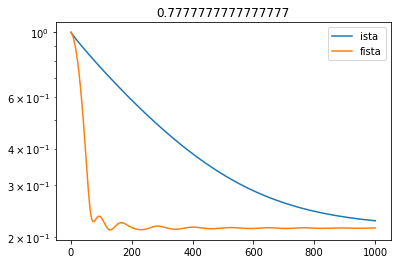

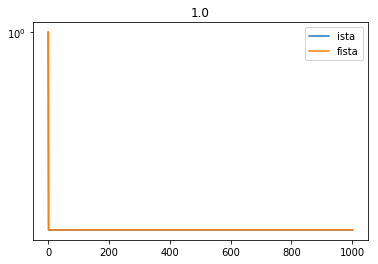

In [117]:
corr_list = np.linspace(-1,1,10)
for c in corr_list:
    A, b = simu_linreg(coefs, n_samples=1000,corr = c)
    x_ista1, objectives_ista1, errors_ista1 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                  step=1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)

    x_fista1, objectives_fista1, errors_fista1 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                    step=1/lip_linreg(A), s=s, n_iter=1000, x_true=coefs, verbose=False)
    plt.semilogy(errors_ista1)
    plt.semilogy(errors_fista1)
    plt.title(str(c))
    plt.legend(['ista','fista'])
    plt.show()
    

## Explication :when the correlation  of the features is changed and fixed, in linear Regression with Ridge, there is a change in ISTA and FISTA. More the value of Correlation increase, more ISTA and FISTA take the time to converge to the same value. 

## In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms

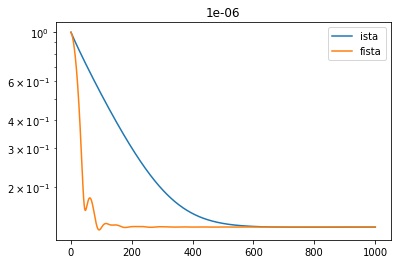

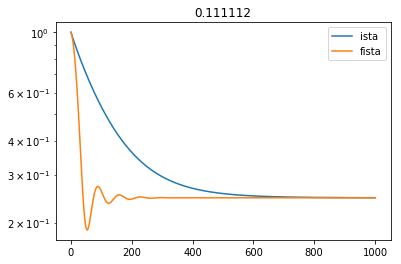

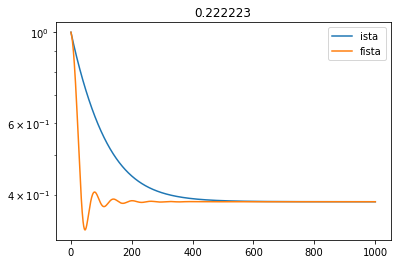

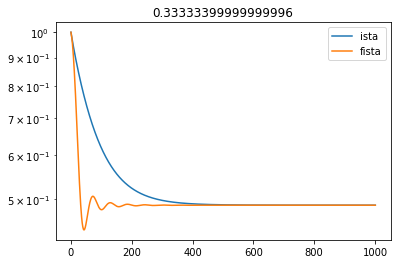

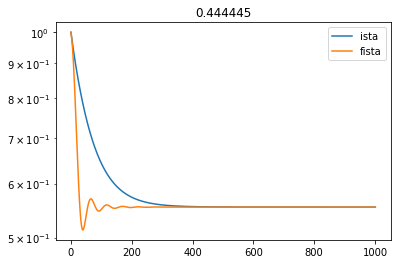

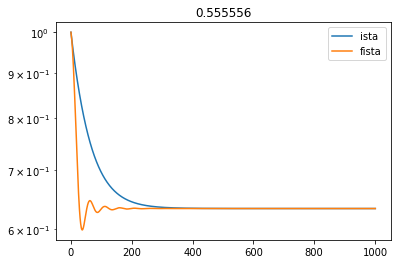

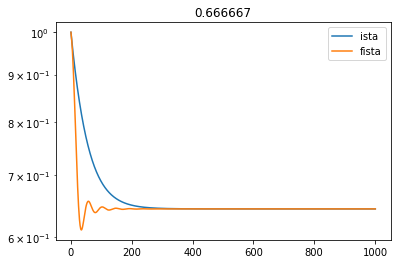

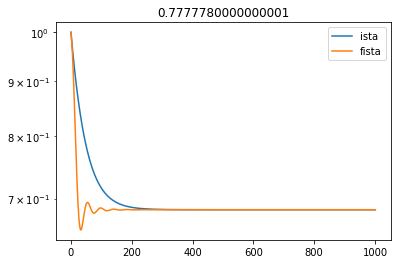

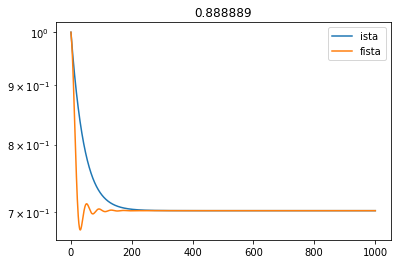

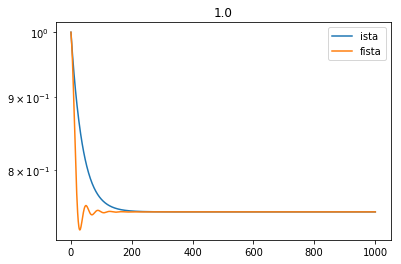

In [118]:
s =np.linspace(1e-6,1,10)
for i in range(len(s)):
    A, b = simu_linreg(coefs, n_samples=1000,corr = 0.5)
    x_ista2, objectives_ista2, errors_ista2 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                  1/lip_linreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)

    x_fista2, objectives_fista2, errors_fista2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge,\
                                    1/lip_linreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)
    plt.semilogy(errors_ista2)
    plt.semilogy(errors_fista2)
    plt.title(str(s[i]))
    plt.legend(['ista','fista'])
    plt.show()

## Explaination : When the correlation is fixe, and S change the value(the value incease) ISTA and FISTA take few time to converge for the linear regression and Ridge. One observation is that FISTA decrease so faste.

## In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge penalizations.

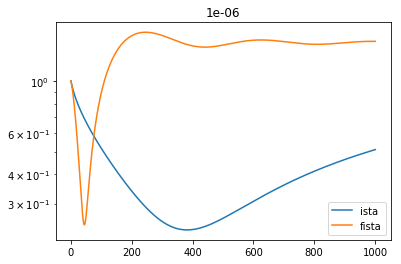

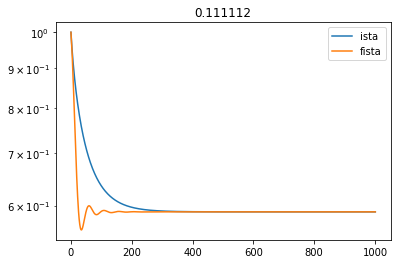

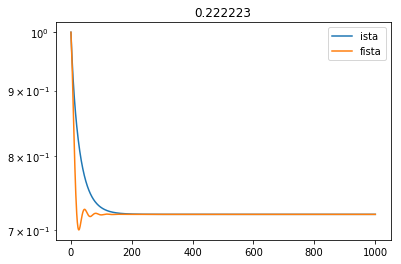

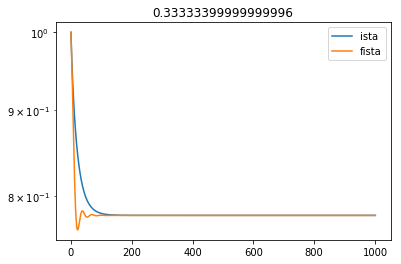

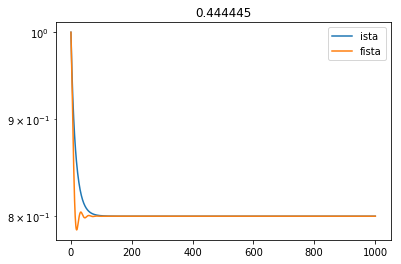

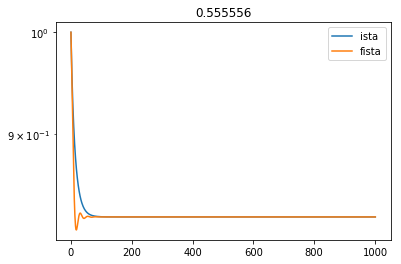

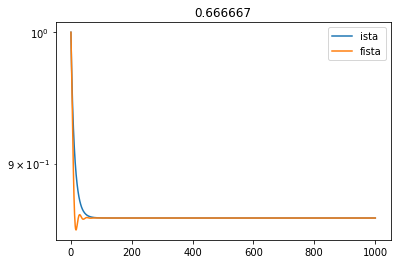

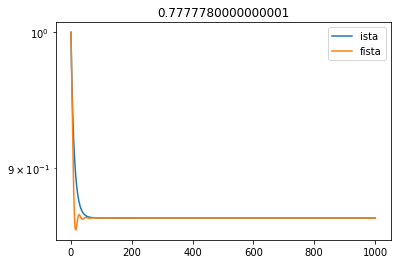

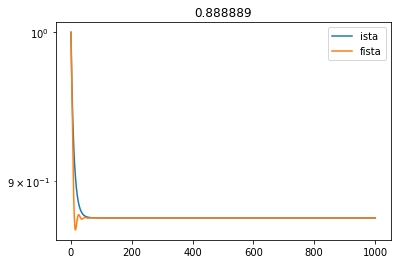

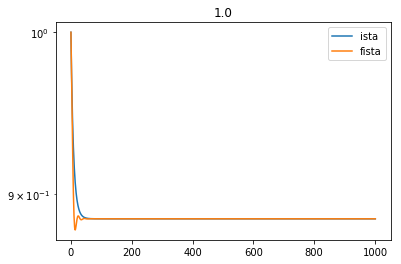

In [119]:
s =np.linspace(1e-6,1,10)
for i in range(len(s)):
    A, b = simu_linreg(coefs, n_samples=1000,corr = 0.5)
    x_ista3, objectives_ista3, errors_ista3 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge,\
                                  1/lip_logreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)

    x_fista3, objectives_fista3, errors_fista3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge,\
                                    1/lip_logreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)
    plt.semilogy(errors_ista3)
    plt.semilogy(errors_fista3)
    plt.title(str(s[i]))
    plt.legend(['ista','fista'])
    plt.show()

## Explaination : When the correlation is fixe, and S change the value(the value incease) ISTA and FISTA take few time to converge to the same value for the logistic regression and Ridge.One observation is that FISTA decrease so faste. At the first time, ISTA and FISTA are divergent.

## In linear regression and logistic regression, compare the performance of the optimization algorithms for lasso penalizations.

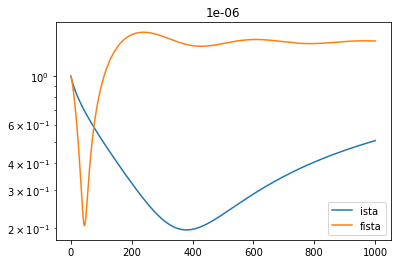

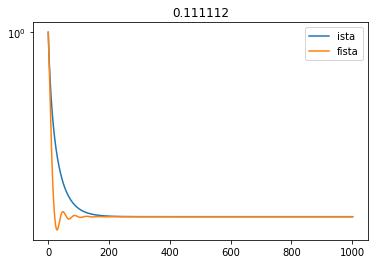

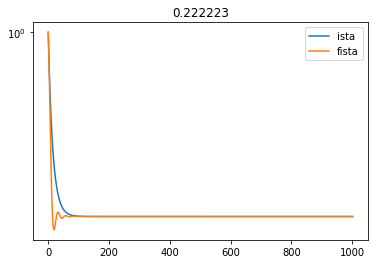

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


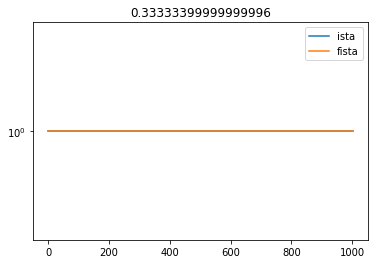

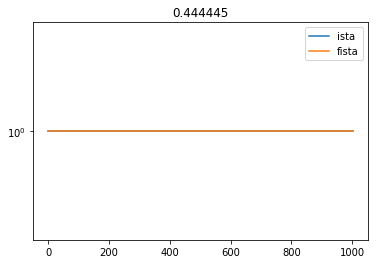

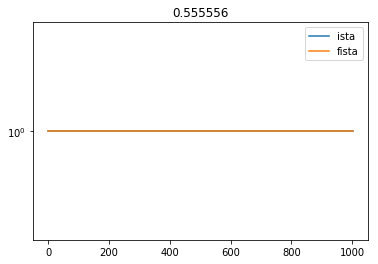

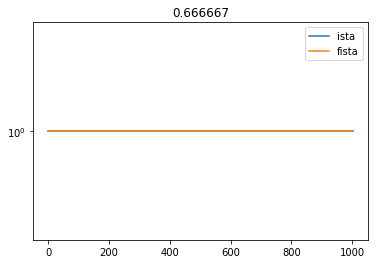

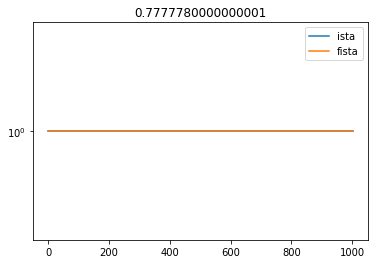

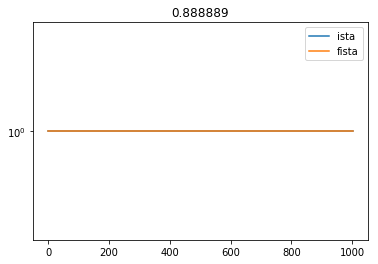

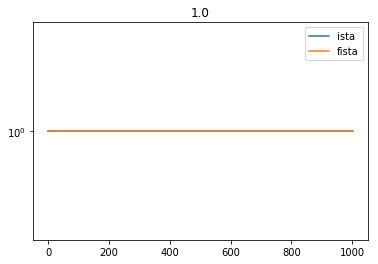

In [122]:
s =np.linspace(1e-6,1,10)
for i in range(len(s)):
    A, b = simu_linreg(coefs, n_samples=1000,corr = 0.5)
    x_ista4, objectives_ista4, errors_ista4 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso,\
                                  1/lip_logreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)

    x_fista4, objectives_fista4, errors_fista4 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso,\
                                    1/lip_logreg(A), s=s[i], n_iter=1000, x_true=coefs, verbose=False)
    plt.semilogy(errors_ista4)
    plt.semilogy(errors_fista4)
    plt.title(str(s[i]))
    plt.legend(['ista','fista'])
    plt.show()

## Explaination : When the correlation is fixe, and S change the value(the value incease) ISTA and FISTA diverge at the firt time for the small value of S. When the value of S increase, ISTA and FISTA converge to the same value for the logistic regression and Ridge.One observation is that FISTA decrease so faste. At the first time.